# LLMs with tools

In [1]:
import numpy as np
import pandas as pd
import math
import json
import re
import os
from pymatgen.core.structure import Structure
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from dotenv import load_dotenv
from pymatgen.core.composition import Composition

In [2]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate

OPENAI_MODEL="gpt-4o" # "gpt-3.5-turbo", "gpt-4o-mini", "gpt-4o"
# see the list of availible models https://platform.openai.com/docs/models
load_dotenv()
openai_api_key = os.environ.get('OPENAI_API_KEY')

In [3]:
from typing import Annotated, TypedDict, Dict
from langchain.agents import tool

@tool
def dir_name(pseudo_potentials_folder: str,
             functional: str, 
             mode: str) -> str:
    '''
    Function to determine the path to the folder with the correct pseudopotentials
    Args: 
         pseudo_potentials_folder: str, name of the parent forlder with pseudopotentials
         functional: str, name of the DFT functional
         mode: str, mode for pseudopotential, list of possible values: ["efficiency", "precision"]
    '''
    list_of_subfolders=os.listdir(pseudo_potentials_folder)
    for subfolder in list_of_subfolders:
        if(re.search(functional.lower()+"_", subfolder.lower()) and re.search(mode.lower(), subfolder.lower())):
            return pseudo_potentials_folder+"/"+subfolder+"/"

@tool
def list_of_pseudos(pseudo_potentials_folder: str, 
                    functional: str,
                    mode: str, 
                    compound: str) -> list:
    '''
    Function to determine the list of names of files with pseudopotentials for the compound
    Args:
        pseudo_potentials_folder: str, name of the parent forlder with pseudopotentials
        functional: str, name of the DFT functional
        mode: str, mode for pseudopotential, list of possible values: ["efficiency", "precision"]
        compound: str, composition of the compound
    '''
    list_of_subfolders=os.listdir(pseudo_potentials_folder)
    for subfolder in list_of_subfolders:
        if(re.search(functional.lower()+"_", subfolder.lower()) and re.search(mode.lower(), subfolder.lower())):
            list_of_files=os.listdir(pseudo_potentials_folder+"/"+subfolder+"/")
    #print('The list of pseudo files is: ', list_of_files[0], ', ...')
    #print(list_of_files)
    list_of_element_files=[]
    for file in list_of_files:
        for element in Composition(compound).elements:
            element=str(element).lower()
            if(file[:len(element)].lower()==element and not file[len(element):len(element)+1].lower().isalpha()):
                list_of_element_files.append(file)
                
    return list_of_element_files

@tool
def cutoff_limits(pseudo_potentials_cutoffs_folder: str, 
                  functional: str,
                  mode: str,
                  compound: str) -> Dict:
    '''
    Function to determine the maximum energy cutoff and density cutoff possible based on cutoff values specified for pseudopotentials
    Args:
        pseudo_potentials_cutoffs: str, the main folder with pseudopotential cutoffs
        functional: str, name of the DFT functional
        mode: str, mode for pseudopotential, list of possible values: ["efficiency", "precision"]
        compound: str, composition of the compound
    Output:
        Dictionary with keys 'max_ecutwfc' and 'max_ecutrho' and float values
    '''
    list_of_cutoff_files=os.listdir(pseudo_potentials_cutoffs_folder)
    for file in list_of_cutoff_files:
        if(re.search(functional.lower()+"_", file.lower()) and re.search(mode.lower(), file.lower())):
            try:
                with open(pseudo_potentials_cutoffs_folder+"/"+file, "r") as f:
                    cutoffs=json.load(f)
            except:
                cutoffs={}
    elements=[str(el) for el in Composition(compound).elements]
    if(cutoffs!={}):
        subset={key:cutoffs[key] for key in elements}
        encutoffs=[subset[i]['cutoff_wfc'] for i in subset.keys()]
        rhocutoffs=[subset[i]['cutoff_rho'] for i in subset.keys()]
        max_ecutoff=min(encutoffs)
        max_rhocutoff=min(rhocutoffs)
    else:
        max_ecutoff=np.nan
        max_rhocutoff=np.nan
    return { 'max_ecutwfc': max_ecutoff, 'max_ecutrho': max_rhocutoff}

def generate_kpoints_grid(lattice, k_density):
    #kpoints = Kpoints.automatic_density(lattice, k_density)
    kpoints = [math.ceil(k_density/x) for x in lattice.abc]
    kpoints.extend([0,0,0])
    return points

@tool
def get_formula(cif_file: str, primitive=False) -> str:
    '''
    Function reads the formula of the compound from structure file
    Args:
        cif_file: str, structure file
        primitive: bool, whether to transform the unit cell to the primitive one or not
    '''
    struct=Structure.from_file(cif_file)
    if(not primitive):
        return struct.formula
    else:
        primitive=SpacegroupAnalyzer(struct)
        primitive=primitive.get_primitive_standard_structure()
        return primitive.formula

@tool
def get_list_of_atomic_positions(cif_file: str, primitive=False) -> str:
    '''
    This function reads the structure file and returns the string with all atomic positions. 
    Atomic positions are in cartesian coordinates, in Angstrom
    Args:
        cif_file: str, structure file
        primitive: bool, whether to transform the unit cell to the primitive one or not
    '''
    struct = Structure.from_file(cif_file)
    if(not primitive):
        atomic_coordinates=''
        for site in struct.sites:
           line = str(site.specie.element)
           for x in site.coords:
               line+=' '+str(x)
           atomic_coordinates+=line+'\n'
        return atomic_coordinates
    else:
        primitive_cell=SpacegroupAnalyzer(struct)
        primitive_cell=primitive_cell.get_primitive_standard_structure()
        atomic_coordinates_primitive=''
        for site in primitive_cell.sites:
           line = str(site.specie.element)
           for x in site.coords:
               line+=' '+str(x)
           atomic_coordinates_primitive+=line+'\n'
        return atomic_coordinates_primitive

@tool
def get_cell_vectors(cif_file: str, primitive: bool = False) -> str:
    '''
    This function reads the structure file and returns the string with the coordinates of vectors for the unit cell. 
    Coordinates of vectors are given in Angstrom
    Args:
        cif_file: str, structure file
        primitive: bool, whether to transform the unit cell to the primitive one or not
    '''
    struct = Structure.from_file(cif_file)
    if(not primitive):
        cell_vectors=''
        for vec in struct.lattice.matrix:
           line=str(vec[0])+' '+str(vec[1])+' '+str(vec[2])+'\n'
           cell_vectors+=line
        return cell_vectors
    else:
        primitive_cell=SpacegroupAnalyzer(struct)
        primitive_cell=primitive_cell.get_primitive_standard_structure()
        primitive_cell_vectors=''
        for vec in primitive_cell.lattice.matrix:
           line=str(vec[0])+' '+str(vec[1])+' '+str(vec[2])+'\n'
           primitive_cell_vectors+=line
        return primitive_cell_vectors


def get_formula_nottool(cif_file: str, primitive=False) -> str:
    '''
    Function reads the formula of the compound from structure file
    Args:
        cif_file: str, structure file
        primitive: bool, whether to transform the unit cell to the primitive one or not
    '''
    struct=Structure.from_file(cif_file)
    if(not primitive):
        return struct.formula
    else:
        primitive=SpacegroupAnalyzer(struct)
        primitive=primitive.get_primitive_standard_structure()
        return primitive.formula

In [4]:
llm = ChatOpenAI(model=OPENAI_MODEL)
tools=[dir_name, list_of_pseudos, cutoff_limits, get_formula, get_list_of_atomic_positions, get_cell_vectors]
llm_with_tools = llm.bind_tools(tools)

In [46]:
structure_dir="structure_files"
pseudo_potentials_folder = "pseudos"
pseudo_potentials_cutoffs_folder = "pseudo_cutoffs"
# compound = "NaCl"
cif_file=structure_dir+"/"+"ICSD_CollCode11084.cif"
functional = "PBE" # the available values are "PBE" and "PBESol"
mode = "efficiency" # the available values "efficiency" and "precision"
primitive=False
try:
    compound = get_formula_nottool(cif_file, primitive)
except: 
    pass

In [47]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant helping to generate input files for Quantum Espresso \
                                for single point energy calculations.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

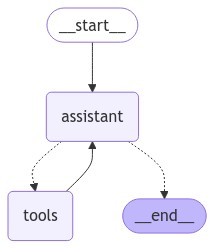

In [48]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [49]:
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "human", "Can you generate the Quantum Espresso input file for compound {compound} for energy calculation \
            for {functional} functional and {mode} mode? \
            The name of the parent folder with pseudopotentials is {pseudo_potentials_folder}.\
            Determine the list of pseudopotential files.\
            The directory with cutoffs is {pseudo_potentials_cutoffs_folder}. Read the structure file {cif_file} for atomic positions and unit cell vectors.\
            Choose a conventional unit cell if {primitive} is False, and convert it to primitive cell if {primitive} is True. \
            Determine the path to the folder with the correct pseudopotentials.\
            Get the list of names of files with pseudopotentials for the compound.\
            Check that the energy cutoff and density cutoff are not larger than the maximum cutoff values \
            for pseudopotentials used."
        ),
    ]
)

In [50]:
messages=prompt.invoke(
    { 
        "compound": compound,
        "pseudo_potentials_folder": pseudo_potentials_folder,
        "pseudo_potentials_cutoffs_folder": pseudo_potentials_cutoffs_folder,
        "mode": mode,
        "functional": functional, 
        "cif_file": cif_file,
        "primitive": primitive, 
    }
).messages

In [ ]:
messages = react_graph.invoke({"messages": messages})

In [ ]:
for m in messages['messages']:
    m.pretty_print()

In [ ]:
with open('generated_files_test2/'+OPENAI_MODEL+'_'+compound.replace(' ','_')+'_scf.txt','w') as f:
    for m in messages['messages']:
        f.write(m.content+'\n')